## Load Libraries


In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0
os.environ["JAX_CAPTURED_CONSTANTS_REPORT_FRAMES"]="-1"
from pathlib import Path
import jax 
jax.config.update("jax_compilation_cache_dir", (Path.cwd() / "tmp/jax_cache").as_posix())
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
try: 
    jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")
except AttributeError:
    pass  # Skip if not available in this JAX version

try:
    import blackjax
except ModuleNotFoundError:
    print('installing blackjax')
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
from natsort import natsorted
# from fastprogress.fastprogress import progress_bar
from functools import partial

# jax.config.update('jax_platform_name', 'cpu')
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count
from flax import nnx

from tqdm.auto import tqdm
# device = 'gpu' if jax.lib.xla_bridge.get_backend().platform == 'gpu' else 'cpu'
device = 'gpu' if jax.extend.backend.get_backend().platform == 'gpu' else 'cpu'
n_gpus = jax.device_count(backend=device)
print(f"Using {n_gpus} device(s) on {device}")

Using 1 device(s) on gpu


In [2]:
from TiDHy.models.TiDHy_nnx_vmap import TiDHy
from TiDHy.models.TiDHy_nnx_vmap_training import train_model, evaluate_record, load_model, get_latest_checkpoint_epoch, list_checkpoints
from TiDHy.datasets.datasets_dynamax import *
from TiDHy.datasets.load_data import load_data, stack_data
from TiDHy.utils import io_dict_to_hdf5 as ioh5
from TiDHy.utils.path_utils import *

##### Plotting settings ######
import matplotlib as mpl
mpl.rcParams.update({'font.size':          10,
                     'axes.linewidth':     2,
                     'xtick.major.size':   5,
                     'ytick.major.size':   5,
                     'xtick.major.width':  2,
                     'ytick.major.width':  2,
                     'axes.spines.right':  False,
                     'axes.spines.top':    False,
                     'pdf.fonttype':       42,
                     'ps.fonttype':        42,
                     'xtick.labelsize':    10,
                     'ytick.labelsize':    10,
                     'figure.facecolor':   'white',
                     'pdf.use14corefonts': True,
                     'font.family':        'sans-serif',
                    #  'font.family':        'Arial',
                    #  'font.sans-serif':    'Arial',
                     'font.serif':         'Arial',
                    })

from matplotlib.colors import ListedColormap
clrs = ['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000']
cmap = ListedColormap(clrs)
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

def map_discrete_cbar(cmap,N):
    cmap = plt.get_cmap(cmap,N+1)
    bounds = np.arange(-.5,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

✓ Applied TFP compatibility patch for JAX 0.8.0


## Load and run

In [5]:
dataset = 'Rossler'
# version = 'HierarchicalMultiTimescale'
version = 'TiDHy'
# base_dir = Path(f'/gscratch/portia/eabe/biomech_model/Flybody/{dataset}/{version}')
base_dir = Path(f'/data2/users/eabe/TiDHy/{dataset}/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    temp = OmegaConf.load(run_cfg)
    print(n, temp.dataset.name, temp.version, run_cfg)

# ###### Load and update config with specified paths template ###### 
cfg_num = 8

# NEW APPROACH: Load config and replace paths using workstation.yaml template
cfg = load_config_and_override_paths(
    config_path=run_cfg_list[cfg_num],
    new_paths_template="workstation",    # Use workstation.yaml for local paths
    config_dir=Path.cwd().parent / "configs",
)

print(f'✅ Loaded experiment: {cfg_num}, {cfg.dataset.name}: {cfg.version} from {run_cfg_list[cfg_num]}')

# Convert string paths to Path objects and create directories
cfg.paths = convert_dict_to_path(cfg.paths)
print("✅ Successfully converted all paths to Path objects and created directories")

0 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline01/logs/run_config.yaml
1 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline02/logs/run_config.yaml
2 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline03/logs/run_config.yaml
3 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline04/logs/run_config.yaml
4 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline05/logs/run_config.yaml
5 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline06/logs/run_config.yaml
6 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline07/dataset.rossler_params.rand_proj=False/logs/run_config.yaml
7 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=TiDHy_Baseline07/logs/run_config.yaml
8 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=min_obs01/logs/run_config.yaml
9 Rossler TiDHy /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=saturation01/log

In [6]:
data_dict = load_data(cfg)
# inputs_train = stack_data(data_dict['inputs_train'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
# inputs_test = stack_data(data_dict['inputs_test'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
inputs_test = data_dict['inputs_test'][None]
max_seq_len = inputs_test.shape[1]

Loading existing dataset from /data2/users/eabe/TiDHy/datasets/Rossler/Rossler_N234_seed42.h5...
Selecting observed states: [2, 3, 4]
Adding observation noise (sigma=0.1)...
Applying random projection to dimension 16...
Normalizing observations...
Dataset generated successfully!
  Training observations: (200000, 16)
  Validation observations: (50000, 16)
  Test observations: (50000, 16)
  Observation dimension: 16


In [7]:
# Create RNG
rngs = nnx.Rngs(0)

# Get model params as dict and unpack directly
model_params = OmegaConf.to_container(cfg.model, resolve=True)
# model_params.pop('batch_converge')
model_params['input_dim'] = inputs_test.shape[-1]

model = TiDHy(**model_params, rngs=rngs)
# model.l0 = nnx.data(jnp.zeros(3))
# model.loss_weights = nnx.data(jnp.ones(3))
print(f"\nModel initialized successfully!")
print(f"input_dim: {model.input_dim}, r_dim: {model.r_dim}, r2_dim: {model.r2_dim}, mix_dim: {model.mix_dim}")
jit_model = jax.jit(model)
# out = jit_model(inputs_train)


Model initialized successfully!
input_dim: 16, r_dim: 8, r2_dim: 8, mix_dim: 8


In [8]:
epoch=get_latest_checkpoint_epoch(cfg.paths.ckpt_dir)
loaded_model = load_model(model,cfg.paths.ckpt_dir/f'epoch_{epoch:04d}')

Model weights loaded from /data2/users/eabe/TiDHy/Rossler/TiDHy/run_id=min_obs01/ckpt/epoch_0967


/home/eabe/miniconda3/envs/tidhy/lib/python3.13/site-packages/orbax/checkpoint/_src/serialization/jax_array_handlers.py:701: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [9]:
result_dict = ioh5.load(cfg.paths.log_dir/'evaluation_results.h5')
seq_len = natsorted(list(result_dict.keys()))
W = jnp.stack([result_dict[str(seq)]['W'].reshape(-1, result_dict[str(seq)]['W'].shape[-1]) for seq in seq_len])
I = jnp.stack([result_dict[str(seq)]['I'].reshape(-1, result_dict[str(seq)]['I'].shape[-1]) for seq in seq_len])
Ihat = jnp.stack([result_dict[str(seq)]['I_hat'].reshape(-1, result_dict[str(seq)]['I_hat'].shape[-1]) for seq in seq_len])
Ibar = jnp.stack([result_dict[str(seq)]['I_bar'].reshape(-1, result_dict[str(seq)]['I_bar'].shape[-1]) for seq in seq_len])
R_hat = jnp.stack([result_dict[str(seq)]['R_hat'].reshape(-1, result_dict[str(seq)]['R_hat'].shape[-1]) for seq in seq_len])
R_bar = jnp.stack([result_dict[str(seq)]['R_bar'].reshape(-1, result_dict[str(seq)]['R_bar'].shape[-1]) for seq in seq_len])
R2_hat = jnp.stack([result_dict[str(seq)]['R2_hat'].reshape(-1, result_dict[str(seq)]['R2_hat'].shape[-1]) for seq in seq_len])
Ut = jnp.stack([result_dict[str(seq)]['Ut'].reshape((-1,)+ result_dict[str(seq)]['Ut'].shape[2:]) for seq in seq_len])
W.shape, R2_hat.shape, R_hat.shape, Ut.shape,

((6, 50000, 8), (6, 50000, 8), (6, 50000, 8), (6, 50000, 8, 8))

In [ ]:
# result_dict = {}
# seq_len = [100,200,500,1000,2000,max_seq_len]
# # seq_len = [20000]
# for seq in tqdm(seq_len):
#     inputs_test = stack_data(data_dict['inputs_test'], sequence_length=seq, all_sequence_lengths=seq_len)
#     rng_key = loaded_model.rngs()
#     spatial_loss_rhat_avg, spatial_loss_rbar_avg, temp_loss_avg, result_dict_single = evaluate_record(loaded_model, inputs_test, rng_key)
#     result_dict['{}'.format(seq)] = result_dict_single


# Rossler

In [10]:
%load_ext cuml.accel
from sklearn.cross_decomposition import CCA

In [41]:
n_comps=3
ts = -1
cca = CCA(n_components=n_comps,max_iter=1000)
X_tidhy,Y_tidhy, coeffs = [], [], []
for k in [0,3]:
    X_c,Y_c = cca.fit_transform(R_hat[ts], data_dict['states_x_test'][:,k:k+3])
    cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
    X_tidhy.append(X_c)
    Y_tidhy.append(Y_c)
    coeffs.append(cca_coefficient)
    x_w = cca.x_weights_
    y_w = cca.y_weights_
    cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
    cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],data_dict['states_x_test'][:,n])) for n in range(n_comps)]
    cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[0,:,n])) for n in range(n_comps)]
    for n in range(n_comps):
        print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))
X_tidhy = jnp.concatenate(X_tidhy, axis=-1)
Y_tidhy = jnp.concatenate(Y_tidhy, axis=-1)
coeffs = jnp.concatenate(coeffs, axis=-1)

comp 0, cc: 0.987, ang: 9.31, ang_x:1.2e+02, ang_r:92.4
comp 1, cc: 0.868, ang: 29.7, ang_x:46.5, ang_r:45.9
comp 2, cc: 0.692, ang: 46.2, ang_x:92.5, ang_r:1.1e+02
comp 0, cc: 0.999, ang: 2.14, ang_x:1.43e+02, ang_r:1.62e+02
comp 1, cc: 0.999, ang: 3.12, ang_x:1.33e+02, ang_r:78.6
comp 2, cc: 0.0936, ang: 84.6, ang_x:77.3, ang_r:90.3


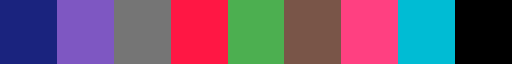

In [14]:
import matplotlib.gridspec as gridspec
from TiDHy.utils.state_annotation_comparison import analyze_state_annotation_correspondence
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53',"#32373B",'#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
cmap_b = ListedColormap(clrs_b)
cmap_b


In [151]:
ts=-1
rossler_params = cfg.dataset.rossler_params
dt = cfg.dataset.rossler_params.dt
rng_key = jax.random.PRNGKey(42)
tolerance=0.01
# 1. Compute ground truth
ground_truth = compute_rossler_ground_truth_timescales(
	data_dict['states_x_test'], dt, rossler_params
)

# Extract ground truth timescales as list
gt_timescales = []
if ground_truth['slow_timescale'] is not None:
	gt_timescales.append(ground_truth['slow_timescale'])
if ground_truth['fast_timescale'] is not None:
	gt_timescales.append(ground_truth['fast_timescale'])


# Effective analysis 
effective_results = analyze_effective_timescales(result_dict[f'{seq_len[ts]}'], dt=dt)

effective_comparison = compare_discovered_to_ground_truth(
	effective_results['all_timescales'],
	gt_timescales,
	tolerance=tolerance
)


/home/eabe/miniconda3/envs/tidhy/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


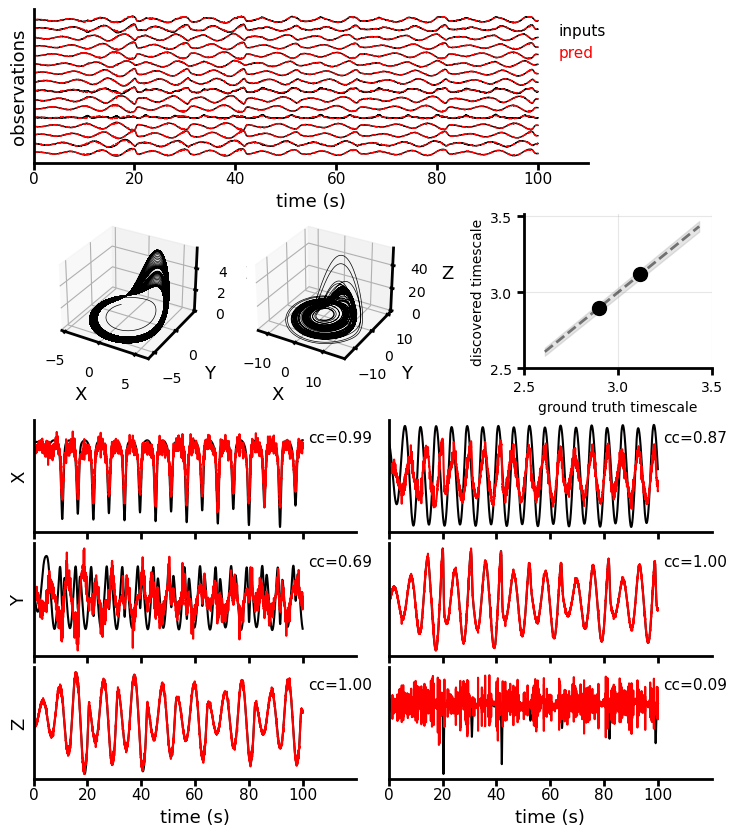

In [152]:
fontsize=13
fig = plt.figure(constrained_layout=True, figsize=(8.75,10))
gs  = gridspec.GridSpec(nrows=8, ncols=6,hspace=1,wspace=.01) 
gs0 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[:2,:], wspace=1,hspace=.1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=gs[2:4,:], wspace=.1,hspace=.1)
gs2 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[4:,:], wspace=.1,hspace=.1)


ax = fig.add_subplot(gs0[:, :-1])
spacing = .5
fps = 1/.01
ts=-1; t = 0; dt = 10000
times = 1/fps* np.arange(0,dt,1)
hlines,hlines_Ihat= [],[]
for n in range(I.shape[-1]):
	mean_centered = I[ts,t:t+dt,n] - np.mean(I[ts,t:t+dt,n],axis=0)
	mean_centered = mean_centered
	ax.plot(times,mean_centered + n/spacing,color='k', lw=1, label='input')
	hlines.append(np.mean(mean_centered + n/spacing,axis=0))
	mean_centered_Ihat = Ihat[ts,t:t+dt,n] - np.mean(Ihat[ts,t:t+dt,n],axis=0)
	ax.plot(times,mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='pred')
	hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))
ax.set_xlim([times[0], times[-1] + 10])
ax.tick_params(axis='x', labelsize=fontsize-2, pad=1)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel("observations",fontsize=fontsize)
ax.set_yticks([])
ax.legend(['inputs', 'pred'], bbox_to_anchor=(0.9, 1), loc='upper left', fontsize=fontsize-2, frameon=False, labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1,columnspacing=.1)



ax = fig.add_subplot(gs1[0:2, :2], projection='3d')
ax.plot(data_dict['states_x_test'][:,0],
data_dict['states_x_test'][:,1],
data_dict['states_x_test'][:,2],
        lw=0.5, c='k')
ax.set_xlabel('X',fontsize=fontsize)
ax.set_ylabel('Y',fontsize=fontsize)
ax.set_zlabel('Z',fontsize=fontsize)
ax = fig.add_subplot(gs1[0:2, 2:4], projection='3d')
ax.plot(data_dict['states_x_test'][:,3],
        data_dict['states_x_test'][:,4],
        data_dict['states_x_test'][:,5],
        lw=0.5, c='k')
ax.set_xlabel('X',fontsize=fontsize)
ax.set_ylabel('Y',fontsize=fontsize)
ax.set_zlabel('Z',fontsize=fontsize)

# ax = fig.add_subplot(gs[0, 0])
ax = fig.add_subplot(gs1[:, 5:])
comparisons = {'Effective': effective_comparison}
colors = plt.cm.tab10(np.linspace(0, 1, len(comparisons)))
all_values = []
for (name, comparison), color in zip(comparisons.items(), colors):
	if comparison is None:
		continue

	matched = comparison['matched_pairs']
	if len(matched) > 0:
		disc_vals = [pair[0] for pair in matched]
		true_vals = [pair[1] for pair in matched]
		ax.scatter(true_vals, disc_vals, alpha=1, s=100,
					label=name, color='k', zorder=5)
		all_values.extend(disc_vals + true_vals)

if len(all_values) > 0:
	# Add y=x line (ideal)
	min_val = min(all_values) * 0.9
	max_val = max(all_values) * 1.1
	ax.plot([min_val, max_val], [min_val, max_val],
			'k--', linewidth=2, label='Ideal (y=x)', alpha=0.5)

	# Add tolerance bounds
	first_comparison = next(iter(comparisons.values()))
	if first_comparison is not None:
		tolerance = first_comparison.get('tolerance', 0.01)
		ax.fill_between([min_val, max_val],
						[min_val * (1-tolerance), max_val * (1-tolerance)],
						[min_val * (1+tolerance), max_val * (1+tolerance)],
						alpha=0.2, color='gray', label=f'±{tolerance*100:.0f}% tolerance',zorder=0)
	ax.set_xlabel('ground truth timescale')
	ax.set_ylabel('discovered timescale')
	ax.grid(True, alpha=0.3)
	ax.set_xticks([2.5, 3, 3.5])
	ax.set_yticks([2.5, 3, 3.5])



axs = np.array([fig.add_subplot(gs2[row,col]) for row in range(3) for col in range(2)])
axs = axs.reshape(3,2)
dims = ['X','Y','Z']
for n in range(6):
	ax = axs.flat[n]
	ax.plot(times, Y_tidhy[t:t+dt,n]/np.max(np.abs(Y_tidhy[:,n])), c='k', label='Y_{}'.format(n))
	ax.plot(times, X_tidhy[t:t+dt,n]/np.max(np.abs(X_tidhy[:,n])), c='r', label='X_{}'.format(n))
	ax.set_yticks([])
	ax.text(0.85, 0.8, f'cc={coeffs[n]:.2f}', transform=ax.transAxes, fontsize=fontsize-2, color='k')
	if n % 2 == 0:
		ax.set_ylabel(f'{dims[n//2]}', fontsize=fontsize)
	if (n>=4):
		ax.set_xlabel('time (s)',fontsize=fontsize)
		ax.tick_params(axis='x', labelsize=fontsize-2, pad=1)
	else: 
		ax.set_xticklabels([])
	ax.set_xlim([times[0], times[-1] + 20])

plt.show()
# fig.savefig(cfg.paths.fig_dir/'SupFigure01_Rossler_TiDHy.pdf', dpi=300, bbox_inches='tight')

# Explore plots

In [33]:
from TiDHy.utils import (
    compute_rossler_ground_truth_timescales,
    compare_discovered_to_ground_truth,
    analyze_hierarchical_rossler_recovery,
    analyze_time_varying_timescales,
    plot_discovered_vs_ground_truth,
    analyze_effective_timescales,
)
import cuml
from sklearn.cluster import HDBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd


Total dimensions: 8
Effective dim (95%): 2
Effective dim (99%): 2
Participation ratio: 1.81


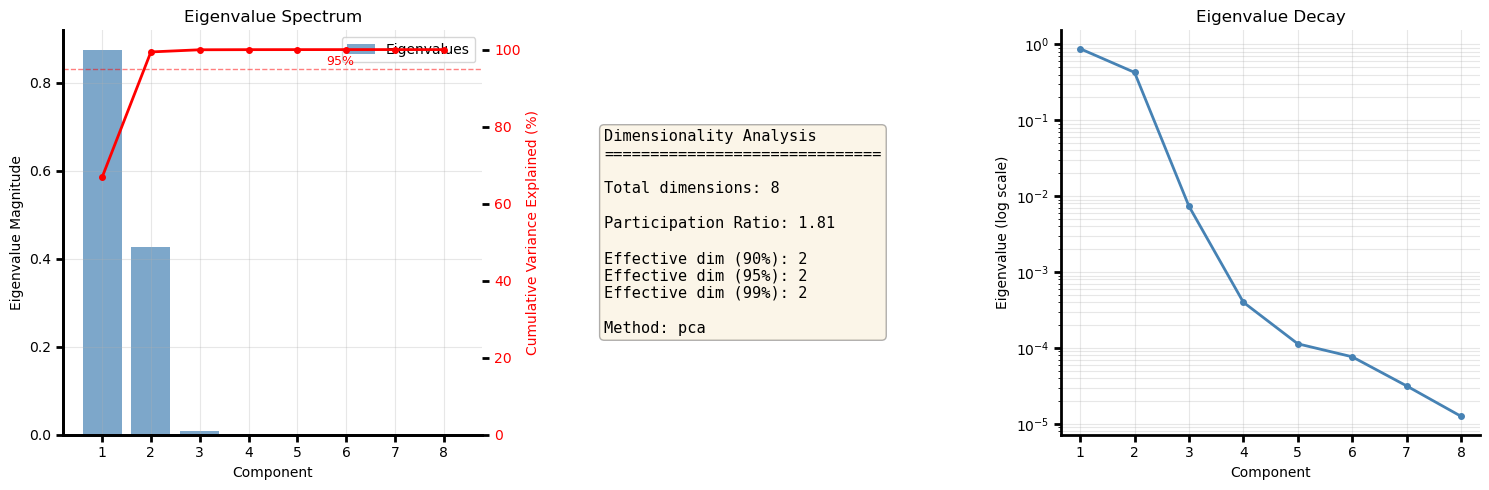

In [34]:
from TiDHy.utils.analysis import analyze_latent_dimension
from TiDHy.utils.analysis_plotting import plot_dimensionality_analysis

ts = -1
# R_hat = result_dict_single['R_hat'].reshape(-1, result_dict_single['R_hat'].shape[-1])

# Analyze effective dimensionality
dim_analysis = analyze_latent_dimension(R_hat[ts], method='pca')

print(f"Total dimensions: {dim_analysis['total_dims']}")
print(f"Effective dim (95%): {dim_analysis['effective_dim_95']}")
print(f"Effective dim (99%): {dim_analysis['effective_dim_99']}")
print(f"Participation ratio: {dim_analysis['participation_ratio']:.2f}")


# Visualize
fig, axes = plot_dimensionality_analysis(dim_analysis)
plt.show()

Discovered timescale range: (0.04342944920063019, 9997.8408203125)
Unique timescales: 3


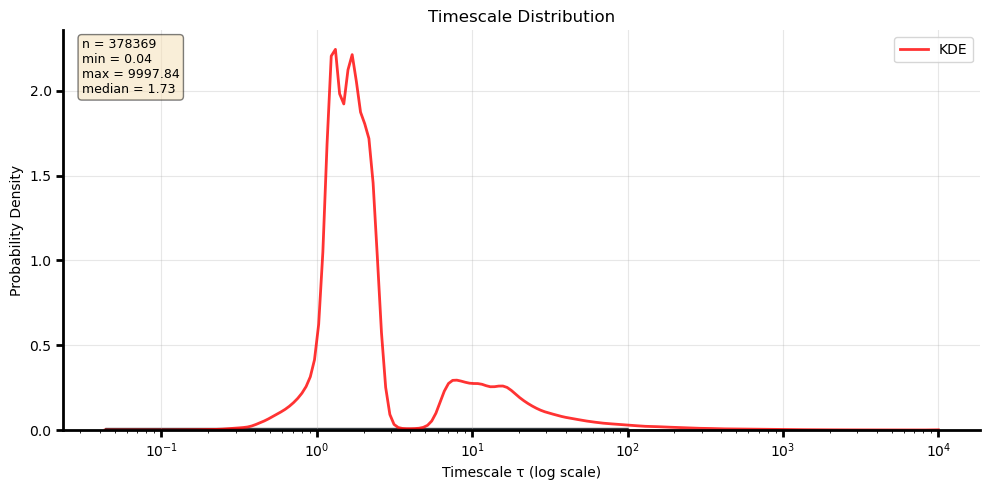

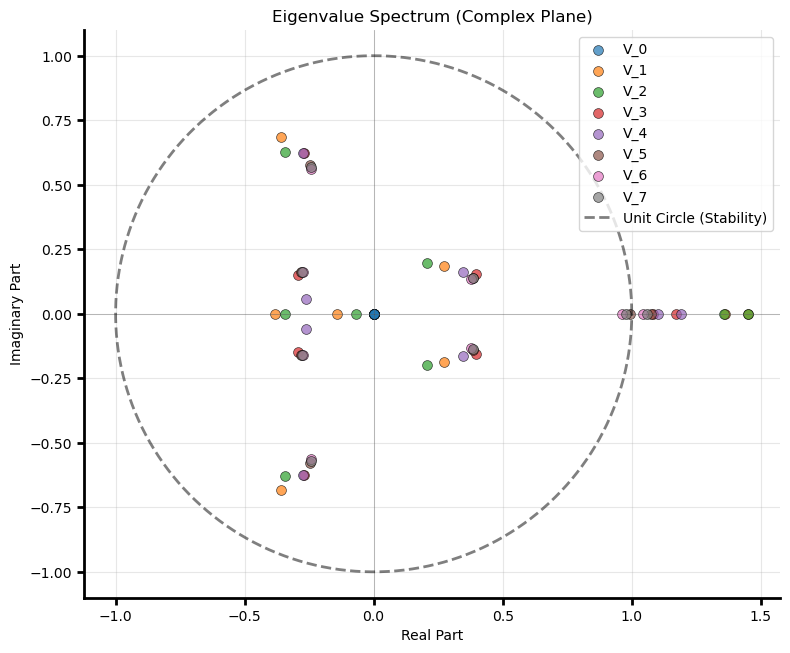

In [35]:
from TiDHy.utils.analysis import analyze_mixture_timescales
from TiDHy.utils.analysis_plotting import plot_timescale_distribution

# Analyze timescales from trained model
# timescale_analysis = analyze_mixture_timescales(model, dt=0.01)
timescale_analysis = analyze_effective_timescales(result_dict[f'{seq_len[ts]}'], dt=1)

print(f"Discovered timescale range: {timescale_analysis['timescale_range']}")
print(f"Unique timescales: {len(timescale_analysis['unique_timescales'])}")
# print(f"Stable modes per component: {timescale_analysis['n_stable_per_timestep']}")

# Visualize timescale distribution
fig, ax = plt.subplots(figsize=(10, 5))
plot_timescale_distribution(timescale_analysis, ax=ax, bins=100)
plt.show()

# Plot eigenvalues in complex plane for each component
from TiDHy.utils import plot_complex_eigenvalues
eigenvalues_list = [spec['eigenvalues'] for spec in timescale_analysis['spectral_results_sample']]
fig, ax = plt.subplots(figsize=(8, 8))
plot_complex_eigenvalues(eigenvalues_list, ax=ax,
                        component_labels=[f'V_{i}' for i in range(model.mix_dim)])
plt.show()


Active components: 3/8
Entropy (normalized): 0.111
Sparsity: 84.38%
Dominant component: 0


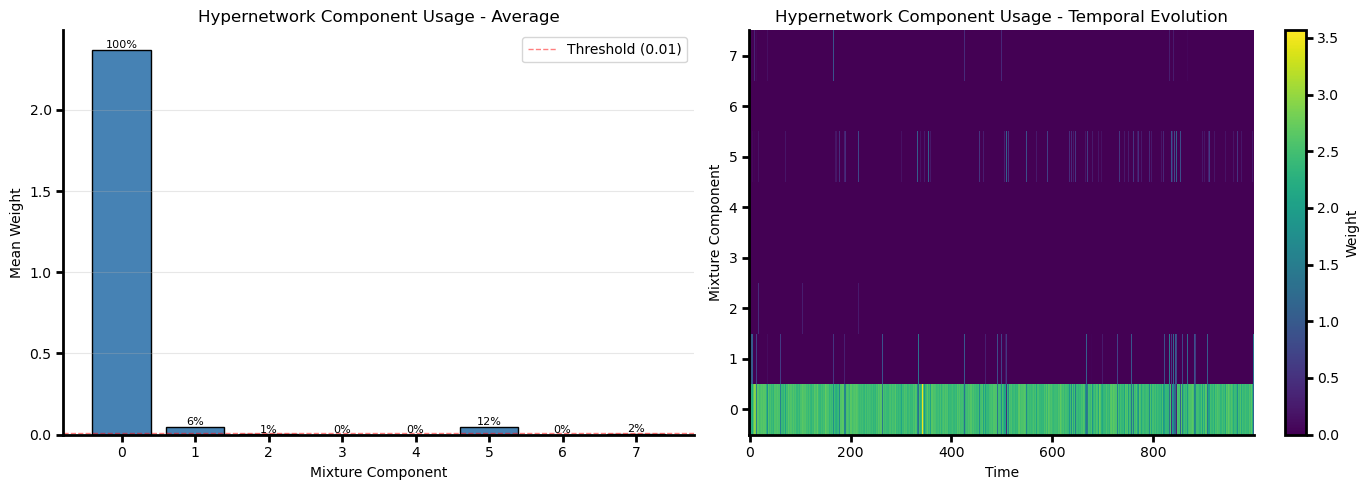

In [39]:

# Example 3: Analyze Hypernetwork Usage

from TiDHy.utils import analyze_hypernetwork_usage, plot_hypernetwork_usage

# W = result_dict_single['W'].reshape(-1, result_dict_single['W'].shape[-1])
ts = -1
# Analyze which components are used
usage_analysis = analyze_hypernetwork_usage(W[ts], threshold=0.01)

print(f"Active components: {usage_analysis['active_components']}/{usage_analysis['mix_dim']}")
print(f"Entropy (normalized): {usage_analysis['entropy']:.3f}")
print(f"Sparsity: {usage_analysis['sparsity']:.2%}")
print(f"Dominant component: {usage_analysis['dominant_component']}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_hypernetwork_usage(W, ax=axes)
plt.show()


In [37]:

# Example 4: Combined Model Selection Workflow

from TiDHy.utils import (
    analyze_latent_dimension,
    analyze_mixture_timescales,
    analyze_hypernetwork_usage
)

# 1. Determine effective r_dim
R_analysis = analyze_latent_dimension(R_hat[ts])
effective_r_dim = R_analysis['effective_dim_95']

# 2. Determine effective r2_dim  
R2_analysis = analyze_latent_dimension(R2_hat[ts])
effective_r2_dim = R2_analysis['effective_dim_95']

# 3. Discover number of timescales (effective mix_dim)
timescale_analysis = analyze_mixture_timescales(model, dt=0.01)
n_unique_timescales = len(timescale_analysis['unique_timescales'])

# 4. Verify with hypernetwork usage
usage_analysis = analyze_hypernetwork_usage(W[ts])
active_components = usage_analysis['active_components']

print("\n" + "="*50)
print("MODEL SELECTION SUMMARY")
print("="*50)
print(f"Recommended r_dim:   {effective_r_dim} (current: {model.r_dim})")
print(f"Recommended r2_dim:  {effective_r2_dim} (current: {model.r2_dim})")
print(f"Recommended mix_dim: {active_components} (current: {model.mix_dim})")
print(f"Discovered timescales: {n_unique_timescales}")
print(f"Timescale range: {timescale_analysis['timescale_range']}")


MODEL SELECTION SUMMARY
Recommended r_dim:   2 (current: 8)
Recommended r2_dim:  3 (current: 8)
Recommended mix_dim: 3 (current: 8)
Discovered timescales: 3
Timescale range: (0.0032176959794014692, 0.011040782555937767)


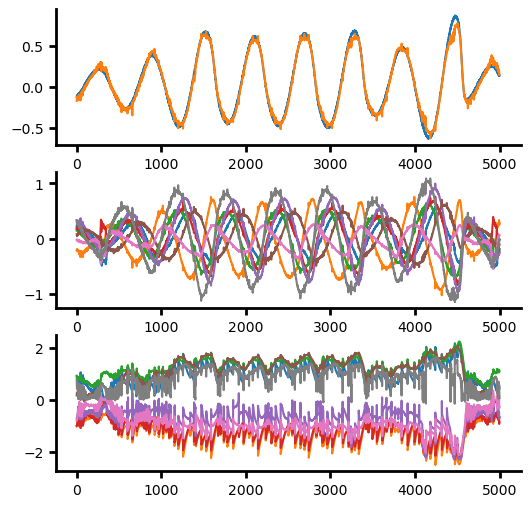

In [38]:
t = 10000
dt = 5000
feature = 0
fig, axs = plt.subplots(3,1,figsize=(6,6))
ax = axs[0]
ax.plot(I[ts,t:t+dt,feature],label='I1')
ax.plot(Ihat[ts,t:t+dt,feature],label='Ihat1')
ax = axs[1]
ax.plot(R_hat[ts,t:t+dt,:],label='R_hat')
ax = axs[2]
ax.plot(R2_hat[ts,t:t+dt,:],label='R_2hat')
# ax.plot(Ihat[ts,:10000,2],label='Ihat3')

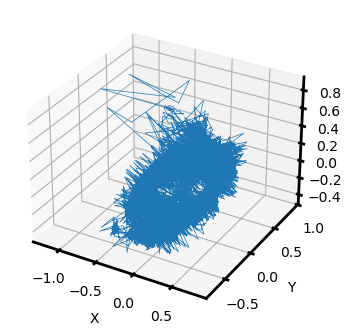

In [29]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(R_hat[ts, :,0],
        R_hat[ts, :,1],
        R_hat[ts, :,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_dict['inputs_train'][:,0],
        data_dict['inputs_train'][:,1],
        data_dict['inputs_train'][:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_dict['states_x_train'][:,0],
        data_dict['states_x_train'][:,1],
        data_dict['states_x_train'][:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_dict['states_x_train'][:,3],
        data_dict['states_x_train'][:,4],
        data_dict['states_x_train'][:,5],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [23]:
effective_results = analyze_effective_timescales(result_dict_single, dt=1/30)
effective_results

{'all_timescales': Array([0.00144765, 0.00144765, 0.03480997, ..., 0.41296852, 0.04190839,
        0.41263255], dtype=float32),
 'timescale_stats': {'mean': 0.33790507912635803,
  'median': 0.05045584589242935,
  'std': 1.5643573999404907,
  'min': 0.001447648392058909,
  'max': 46.625579833984375},
 'unique_timescales': Array([1.61295070e-03, 3.83075490e-03, 5.90359094e-03, 7.32878875e-03,
        9.09804087e-03, 1.12944171e-02, 1.40210250e-02, 1.74058601e-02,
        2.16078423e-02, 2.68242359e-02, 3.32999192e-02, 4.13389094e-02,
        5.13186157e-02, 6.37075081e-02, 7.90872648e-02, 9.81798843e-02,
        1.21881634e-01, 1.51305303e-01, 1.87832221e-01, 2.33177081e-01,
        2.89468795e-01, 3.59349996e-01, 4.46101278e-01, 5.53795338e-01,
        6.87488139e-01, 8.53455782e-01, 1.05949020e+00, 1.31526363e+00,
        1.63278353e+00, 2.02695680e+00, 2.51628828e+00, 3.12374949e+00,
        3.87785935e+00, 4.81402111e+00, 5.97618198e+00, 7.41890192e+00,
        9.20991230e+00, 1.1433

In [24]:
import cupy

ts = 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(R_hat[ts])
umap = cuml.manifold.UMAP(n_components=6, n_neighbors=25, min_dist=0.05, metric='euclidean', random_state=42)
reduced_data = umap.fit_transform(X_scaled)
# reduced_data = umap.fit_transform(R2_hat[ts])

clusterer = cuml.cluster.hdbscan.HDBSCAN(min_cluster_size=500, min_samples=20, cluster_selection_epsilon=0.75, prediction_data=True)
clusterer.fit(reduced_data)
soft_clusters = cuml.cluster.hdbscan.all_points_membership_vectors(clusterer)
labels = clusterer.labels_
l_lab, l_counts = np.unique(labels,return_counts=True)
print(l_lab)
print(l_counts)
print(l_counts[0], sum(l_counts[1:]))

soft_label = jnp.argmax(soft_clusters[:,1:].get() if isinstance(soft_clusters, cupy.ndarray) else soft_clusters[:,1:], axis=1)
reduced_data = reduced_data.get() if isinstance(reduced_data, cupy.ndarray) else reduced_data

[2025-11-18 08:03:05.914] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[-1  0  1  2  3]
[ 1388  1004   650 46241   717]
1388 48612


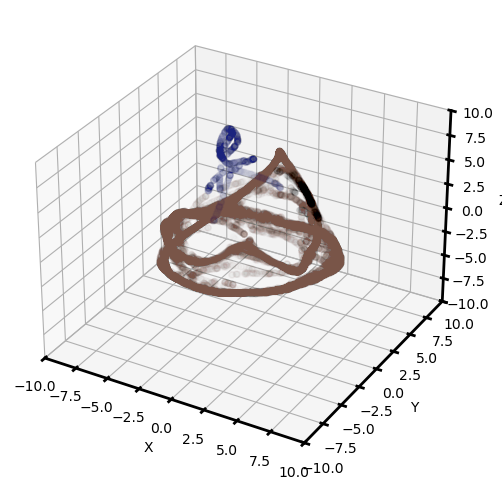

In [25]:
# full_state_z = data_dict['annotations_test'][:reduced_data.shape[0]]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c=soft_label, cmap=cmap, alpha=0.01)
# ax.scatter(reduced_data[:1000,0], reduced_data[:1000,1], reduced_data[:1000,2], c=np.arange(1000), cmap='turbo', alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
ax.set_zlim([-10,10])
# add_colorbar(ax, cmap=cmap, label='True State Z')
plt.show()